In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#d9d9d9", # grey
    ]

PROPOSED_MFE_SUFFIXES = [
            "psi_",
            "overlap_",
            "omv_pth",
            "dc_accuracy",
            "dc_drift_flag",
            "_ks_statistic",
            "_ks_pvalue",
            "sqsi_drift_flag",
            "distance_class_",
            "u_detect_drift_flag",
            "predict",
            "last",
        ]

FINAL_FEATURE_FRACTION = {'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}

In [3]:

TYPE_DICT = {"with_drift": "proposed_mtl", "without_drift": "original_mtl"}

def get_bar_color(row):
    if any(suffix in row["feature"] for suffix in PROPOSED_MFE_SUFFIXES):
        return COLORS[0]
    return COLORS[1]

def _load_data(base_model: str="RandomForestClassifier", dataset: str="electricity", feature_fraction: int=100):
    filename = f"results_importances/base_model: {base_model} - dataset: {dataset} - select_k_features: {feature_fraction}%.json"
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

def _get_mean_importances(data: dict):
    final_df = pd.DataFrame(columns=["feature", "importance", "type", "meta_label"])
    for metric, value in data.items():
        for drift_flag in value.keys():
            importances_df = pd.DataFrame()
            importances_df["importance"] = pd.DataFrame(data[metric][drift_flag]).mean()
            importances_df["type"] = TYPE_DICT[drift_flag]
            importances_df["meta_label"] = metric
            importances_df = importances_df.reset_index().rename(columns={"index": "feature"})
            final_df = pd.concat([final_df, importances_df])
    return final_df

def _plot_results(data: dict, final_df: pd.DataFrame, n_feat_to_plot: int=20, figsize=(25, 35), suptitle="", plot_original=False):
    metrics = list(data.keys())
    drift_flags = list(data['kappa'].keys())
    plt.figure(figsize=figsize)
    plt.suptitle(suptitle, fontsize=25)
    final_df["color"] = final_df.apply(get_bar_color, axis=1)

    for metric_idx, metric in enumerate(metrics):
        for drift_idx, drift_flag in enumerate(drift_flags):
            if not plot_original and drift_flag=="without_drift":
                continue
            plt_idx = metric_idx * 2 + drift_idx + 1 if plot_original else metric_idx + 1
            plt.rcParams.update({'font.size': 22})
            plt.subplot(len(metrics), len(drift_flags) if plot_original else 1, plt_idx)
            plt.title(f"{metric} - {TYPE_DICT[drift_flag]}")
            plot_df = final_df[(final_df["type"] == TYPE_DICT[drift_flag]) & (final_df["meta_label"] == metric)]
            plot_df = plot_df.sort_values(by=["importance"]).tail(n_feat_to_plot)
            plt.barh(plot_df["feature"], plot_df["importance"], color=plot_df["color"])
            plt.tight_layout()
    plt.subplots_adjust(top=0.95)

def run(base_model: str="RandomForestClassifier", dataset: str="electricity", n_feat_to_plot: int=15, figsize: tuple=(25, 35), feature_fraction: int=100, plot_original=False):
    data = _load_data(base_model, dataset, feature_fraction)
    data.pop("auc", None)
    imp_df = _get_mean_importances(data)
    _plot_results(
        data=data,
        final_df=imp_df,
        n_feat_to_plot=n_feat_to_plot,
        figsize=figsize,
        plot_original=plot_original,
        suptitle=f"base_model: {base_model} - dataset: {dataset}")

# Base models

## Decision tree

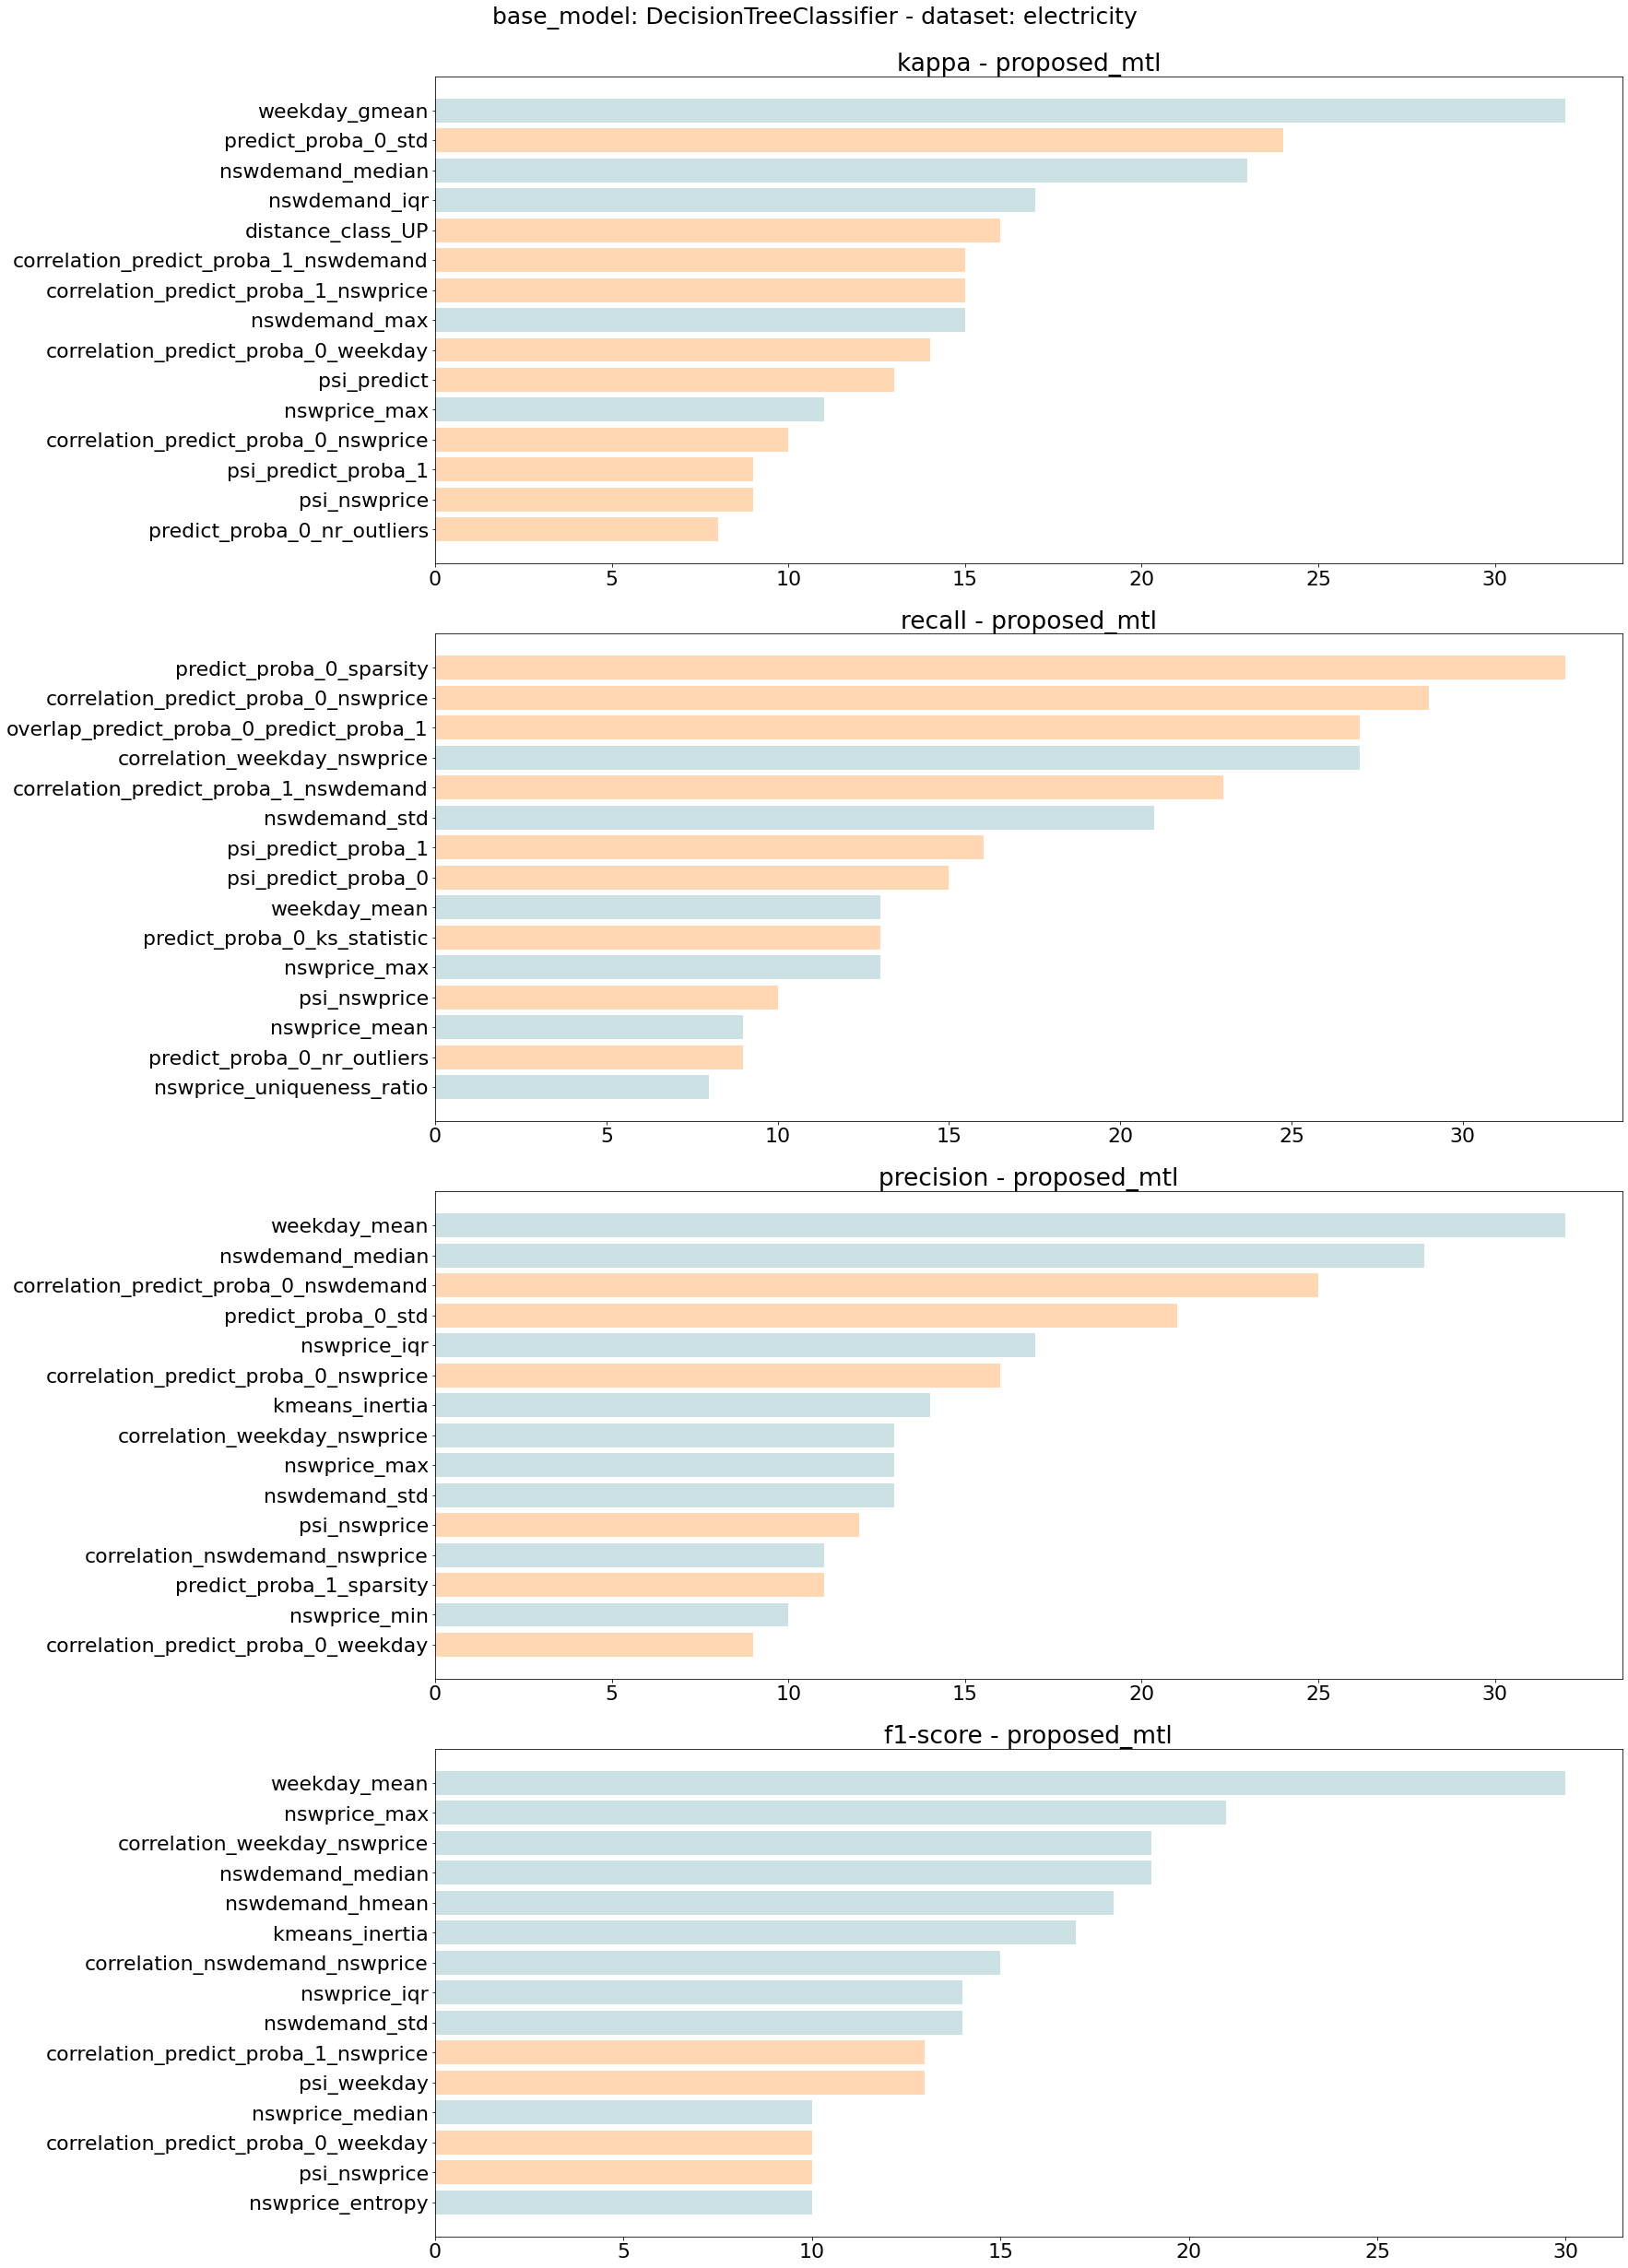

In [4]:
run(base_model="DecisionTreeClassifier", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

## SVM

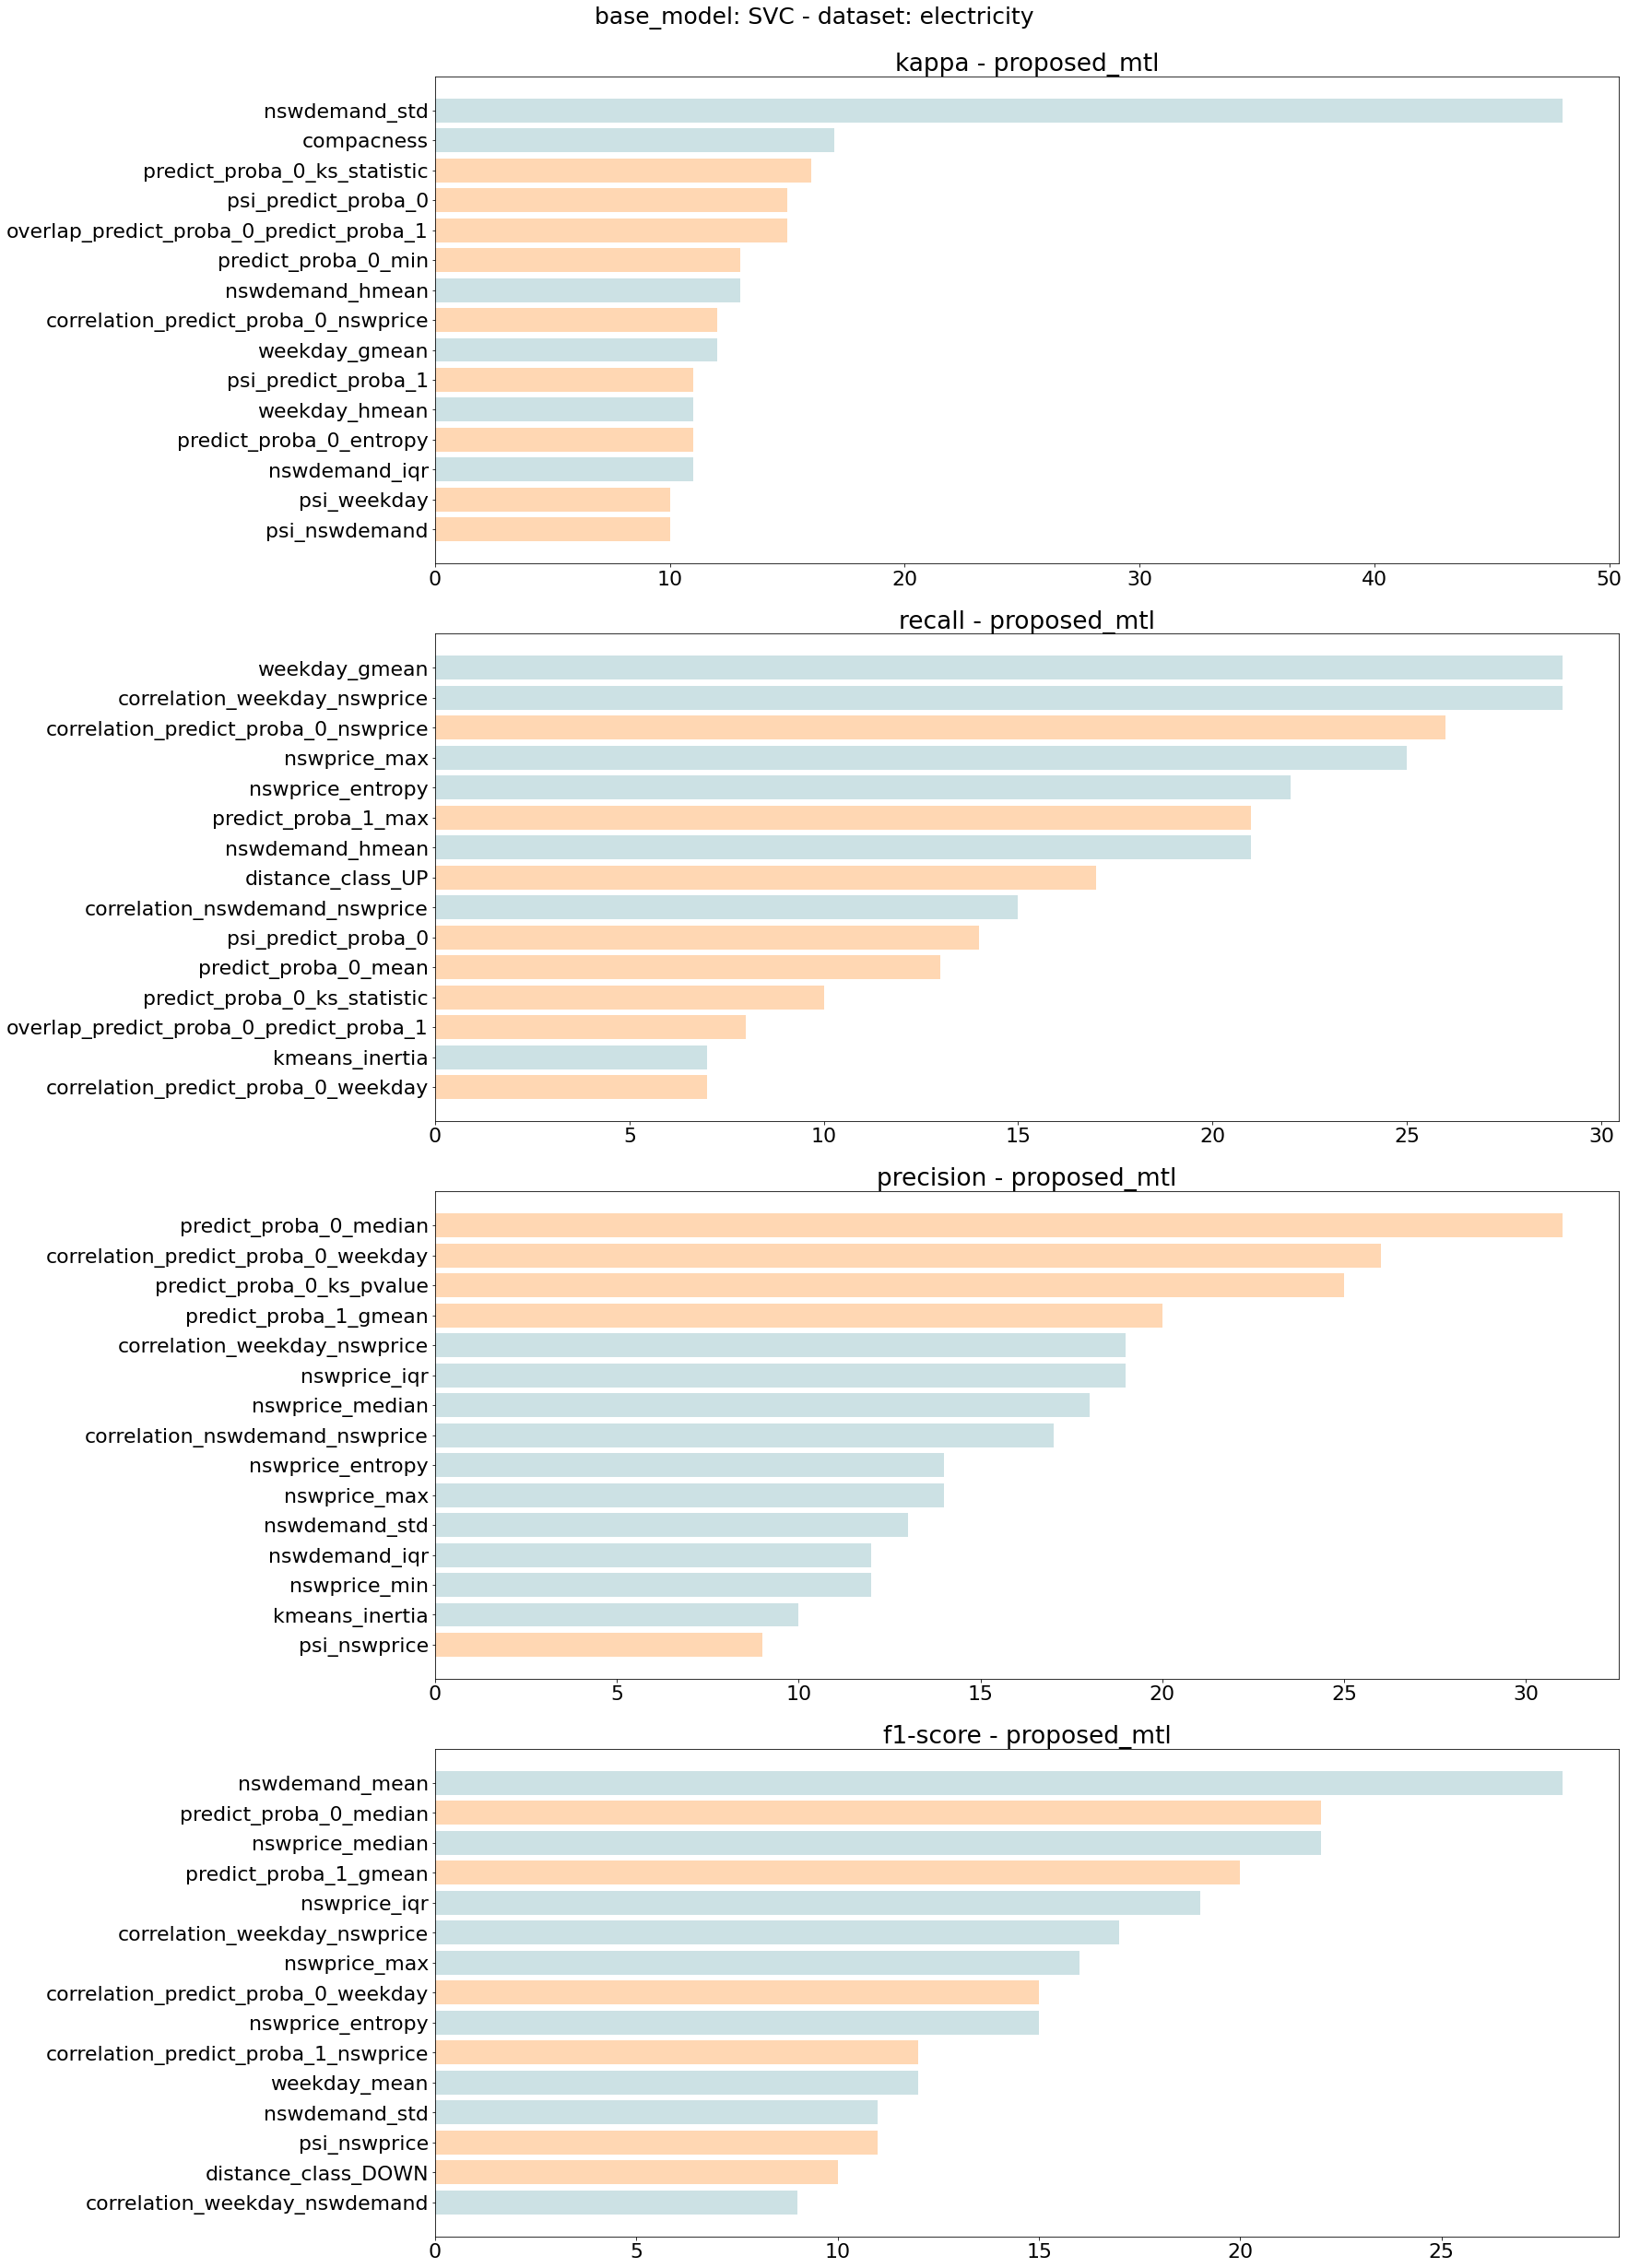

In [5]:
run(base_model="SVC", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

## LogisticRegression

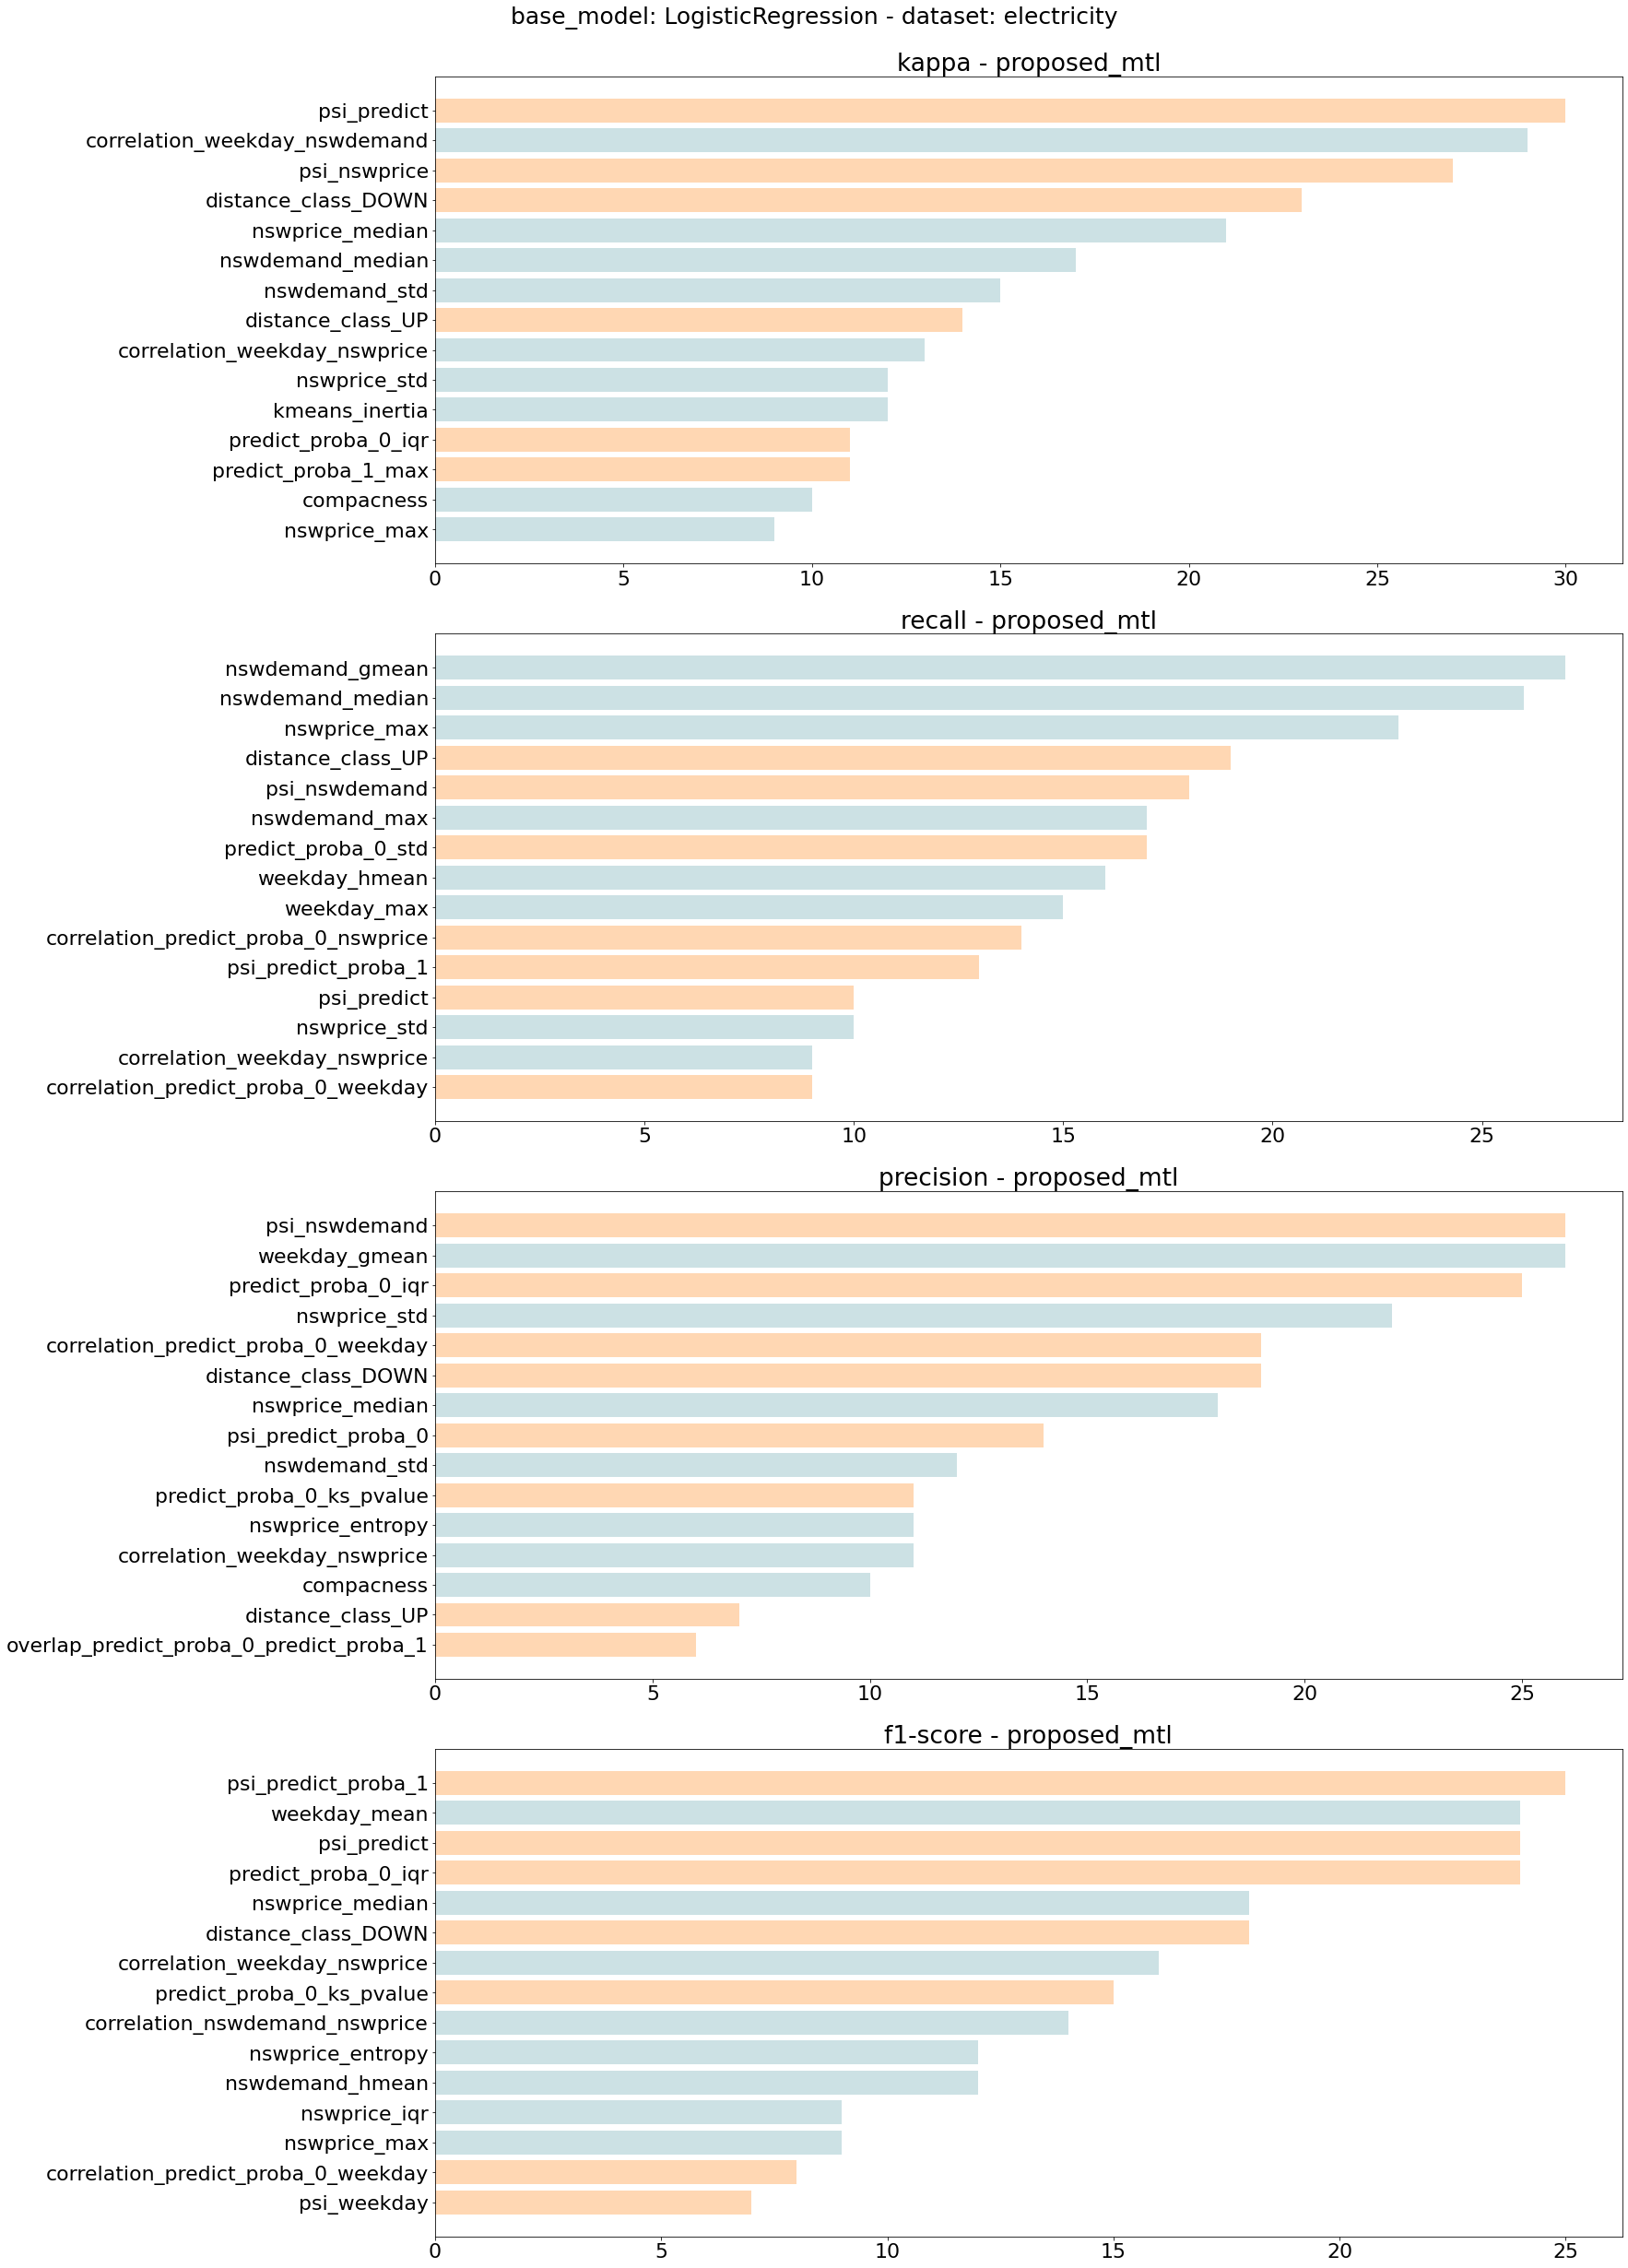

In [6]:
run(base_model="LogisticRegression", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

# Datasets

# Electricity

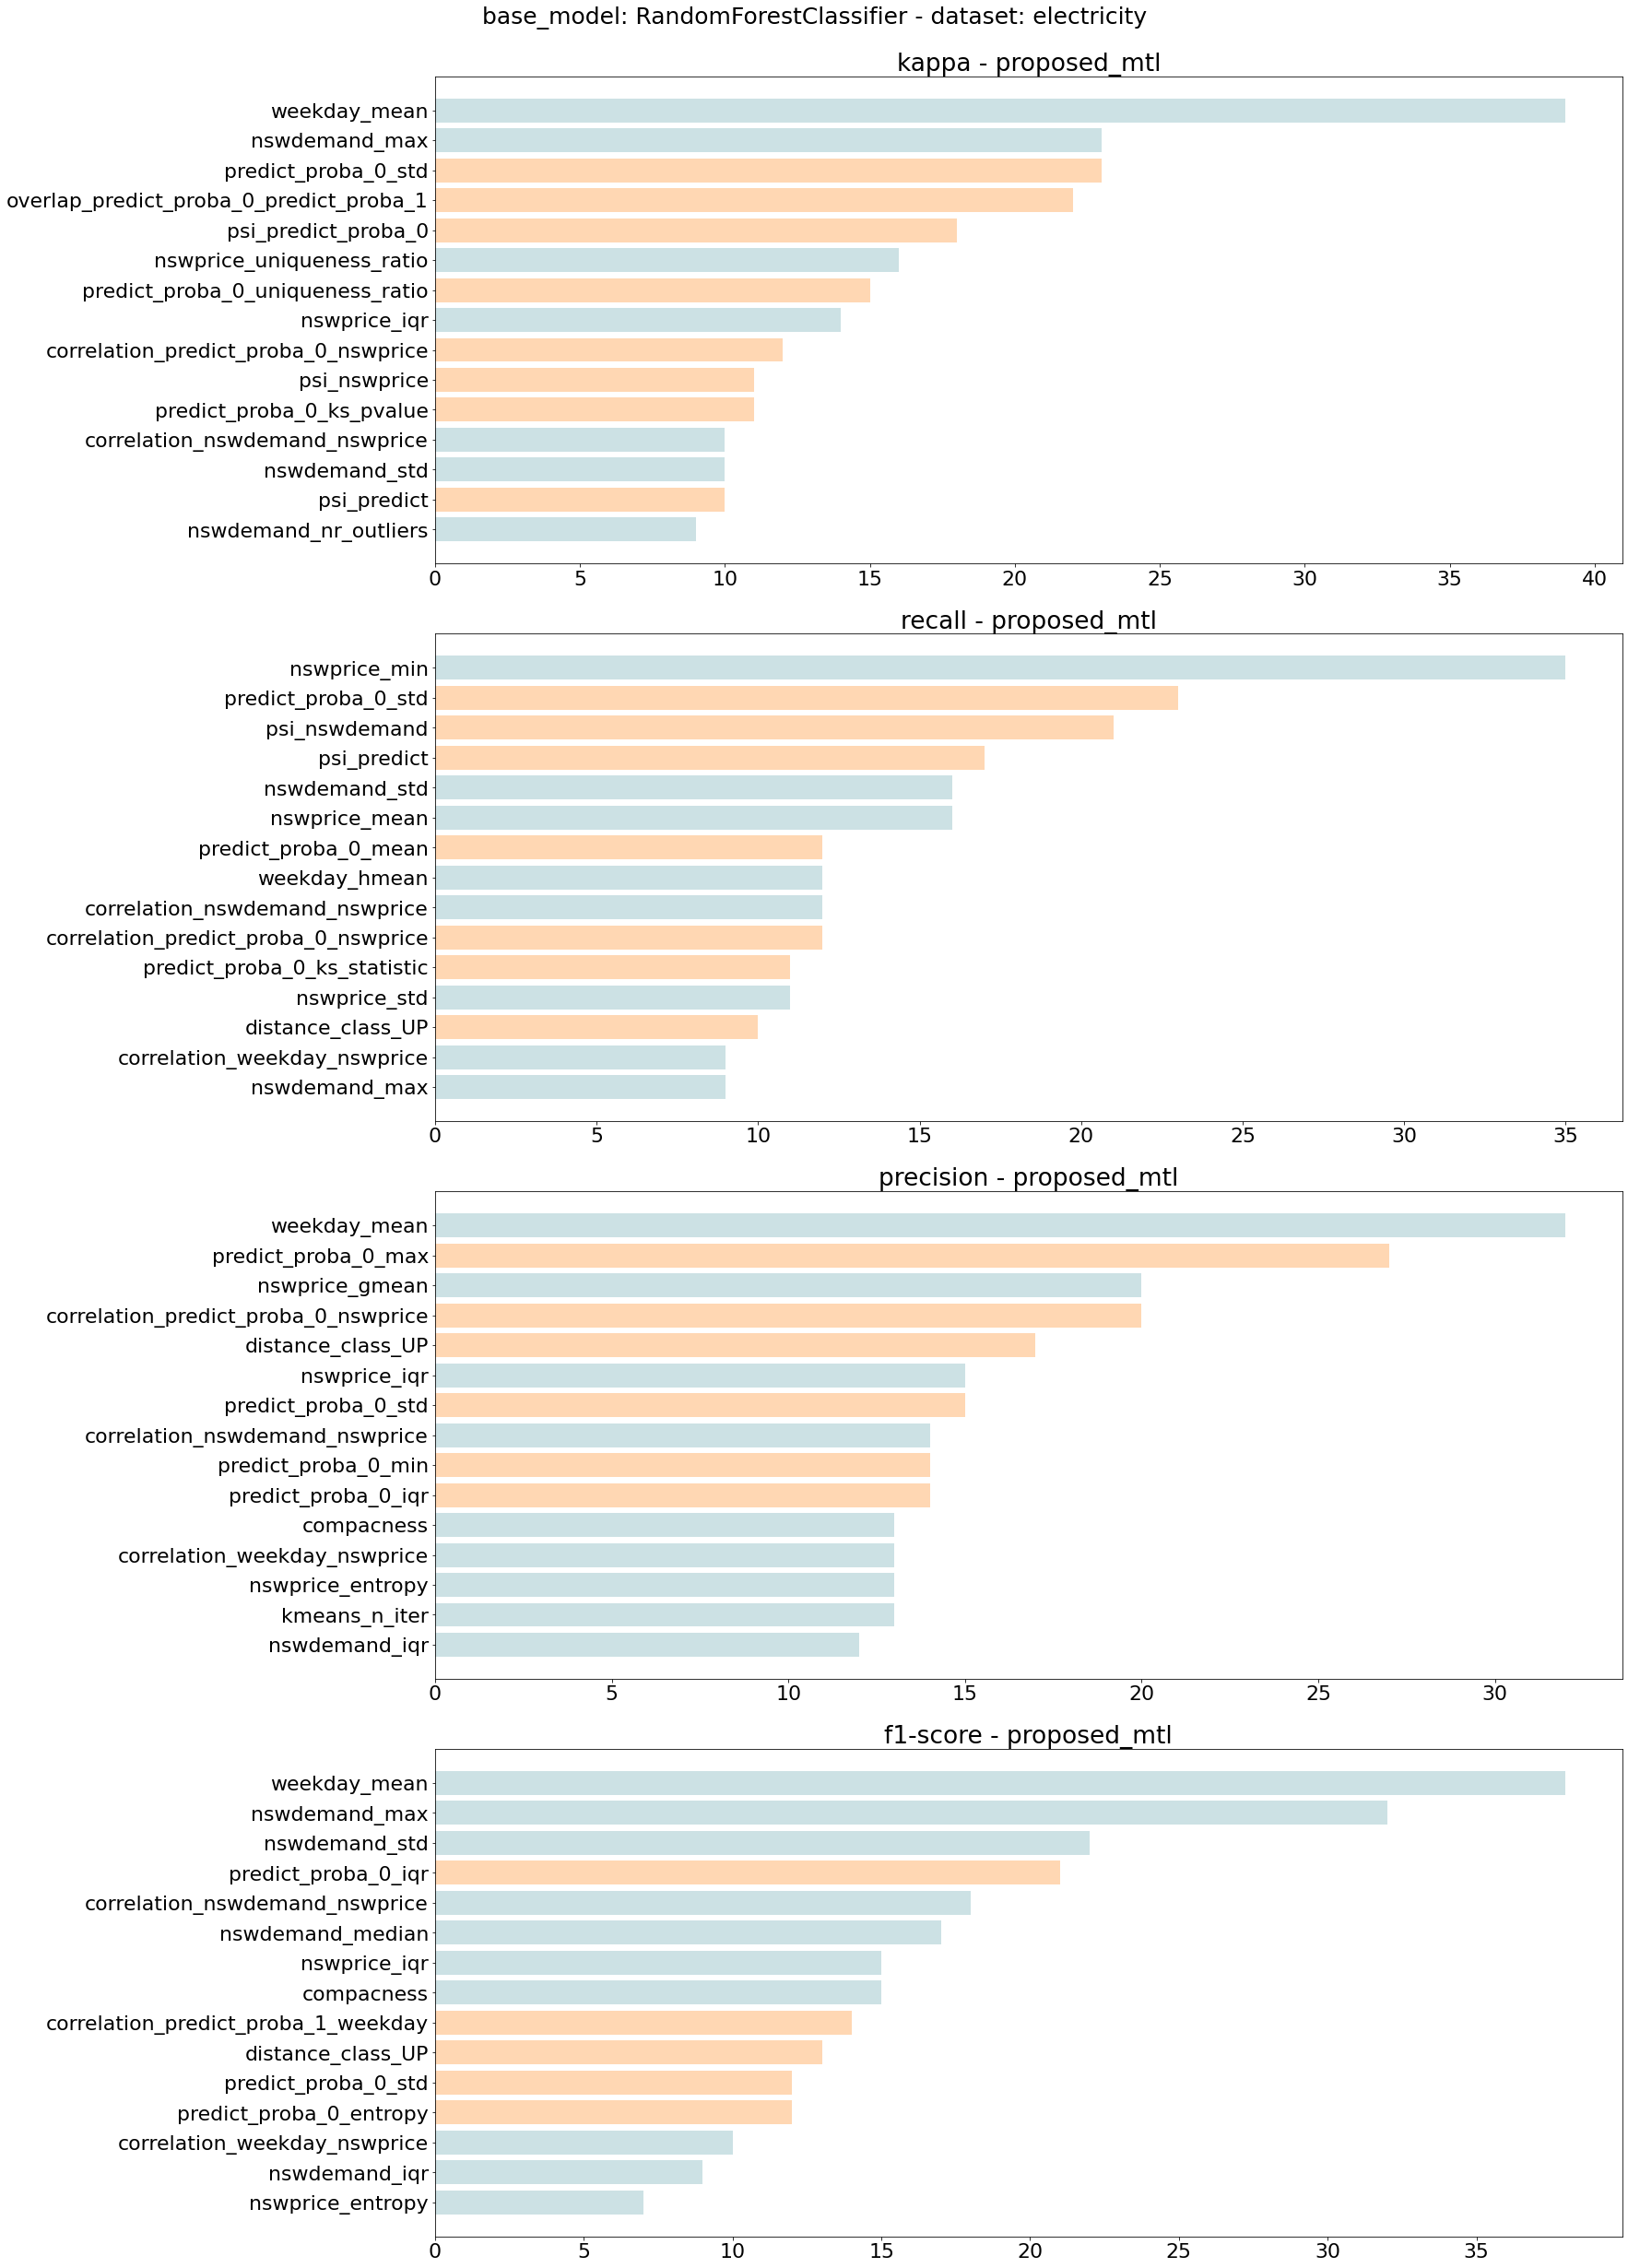

In [7]:
run(base_model="RandomForestClassifier", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

# Airlines

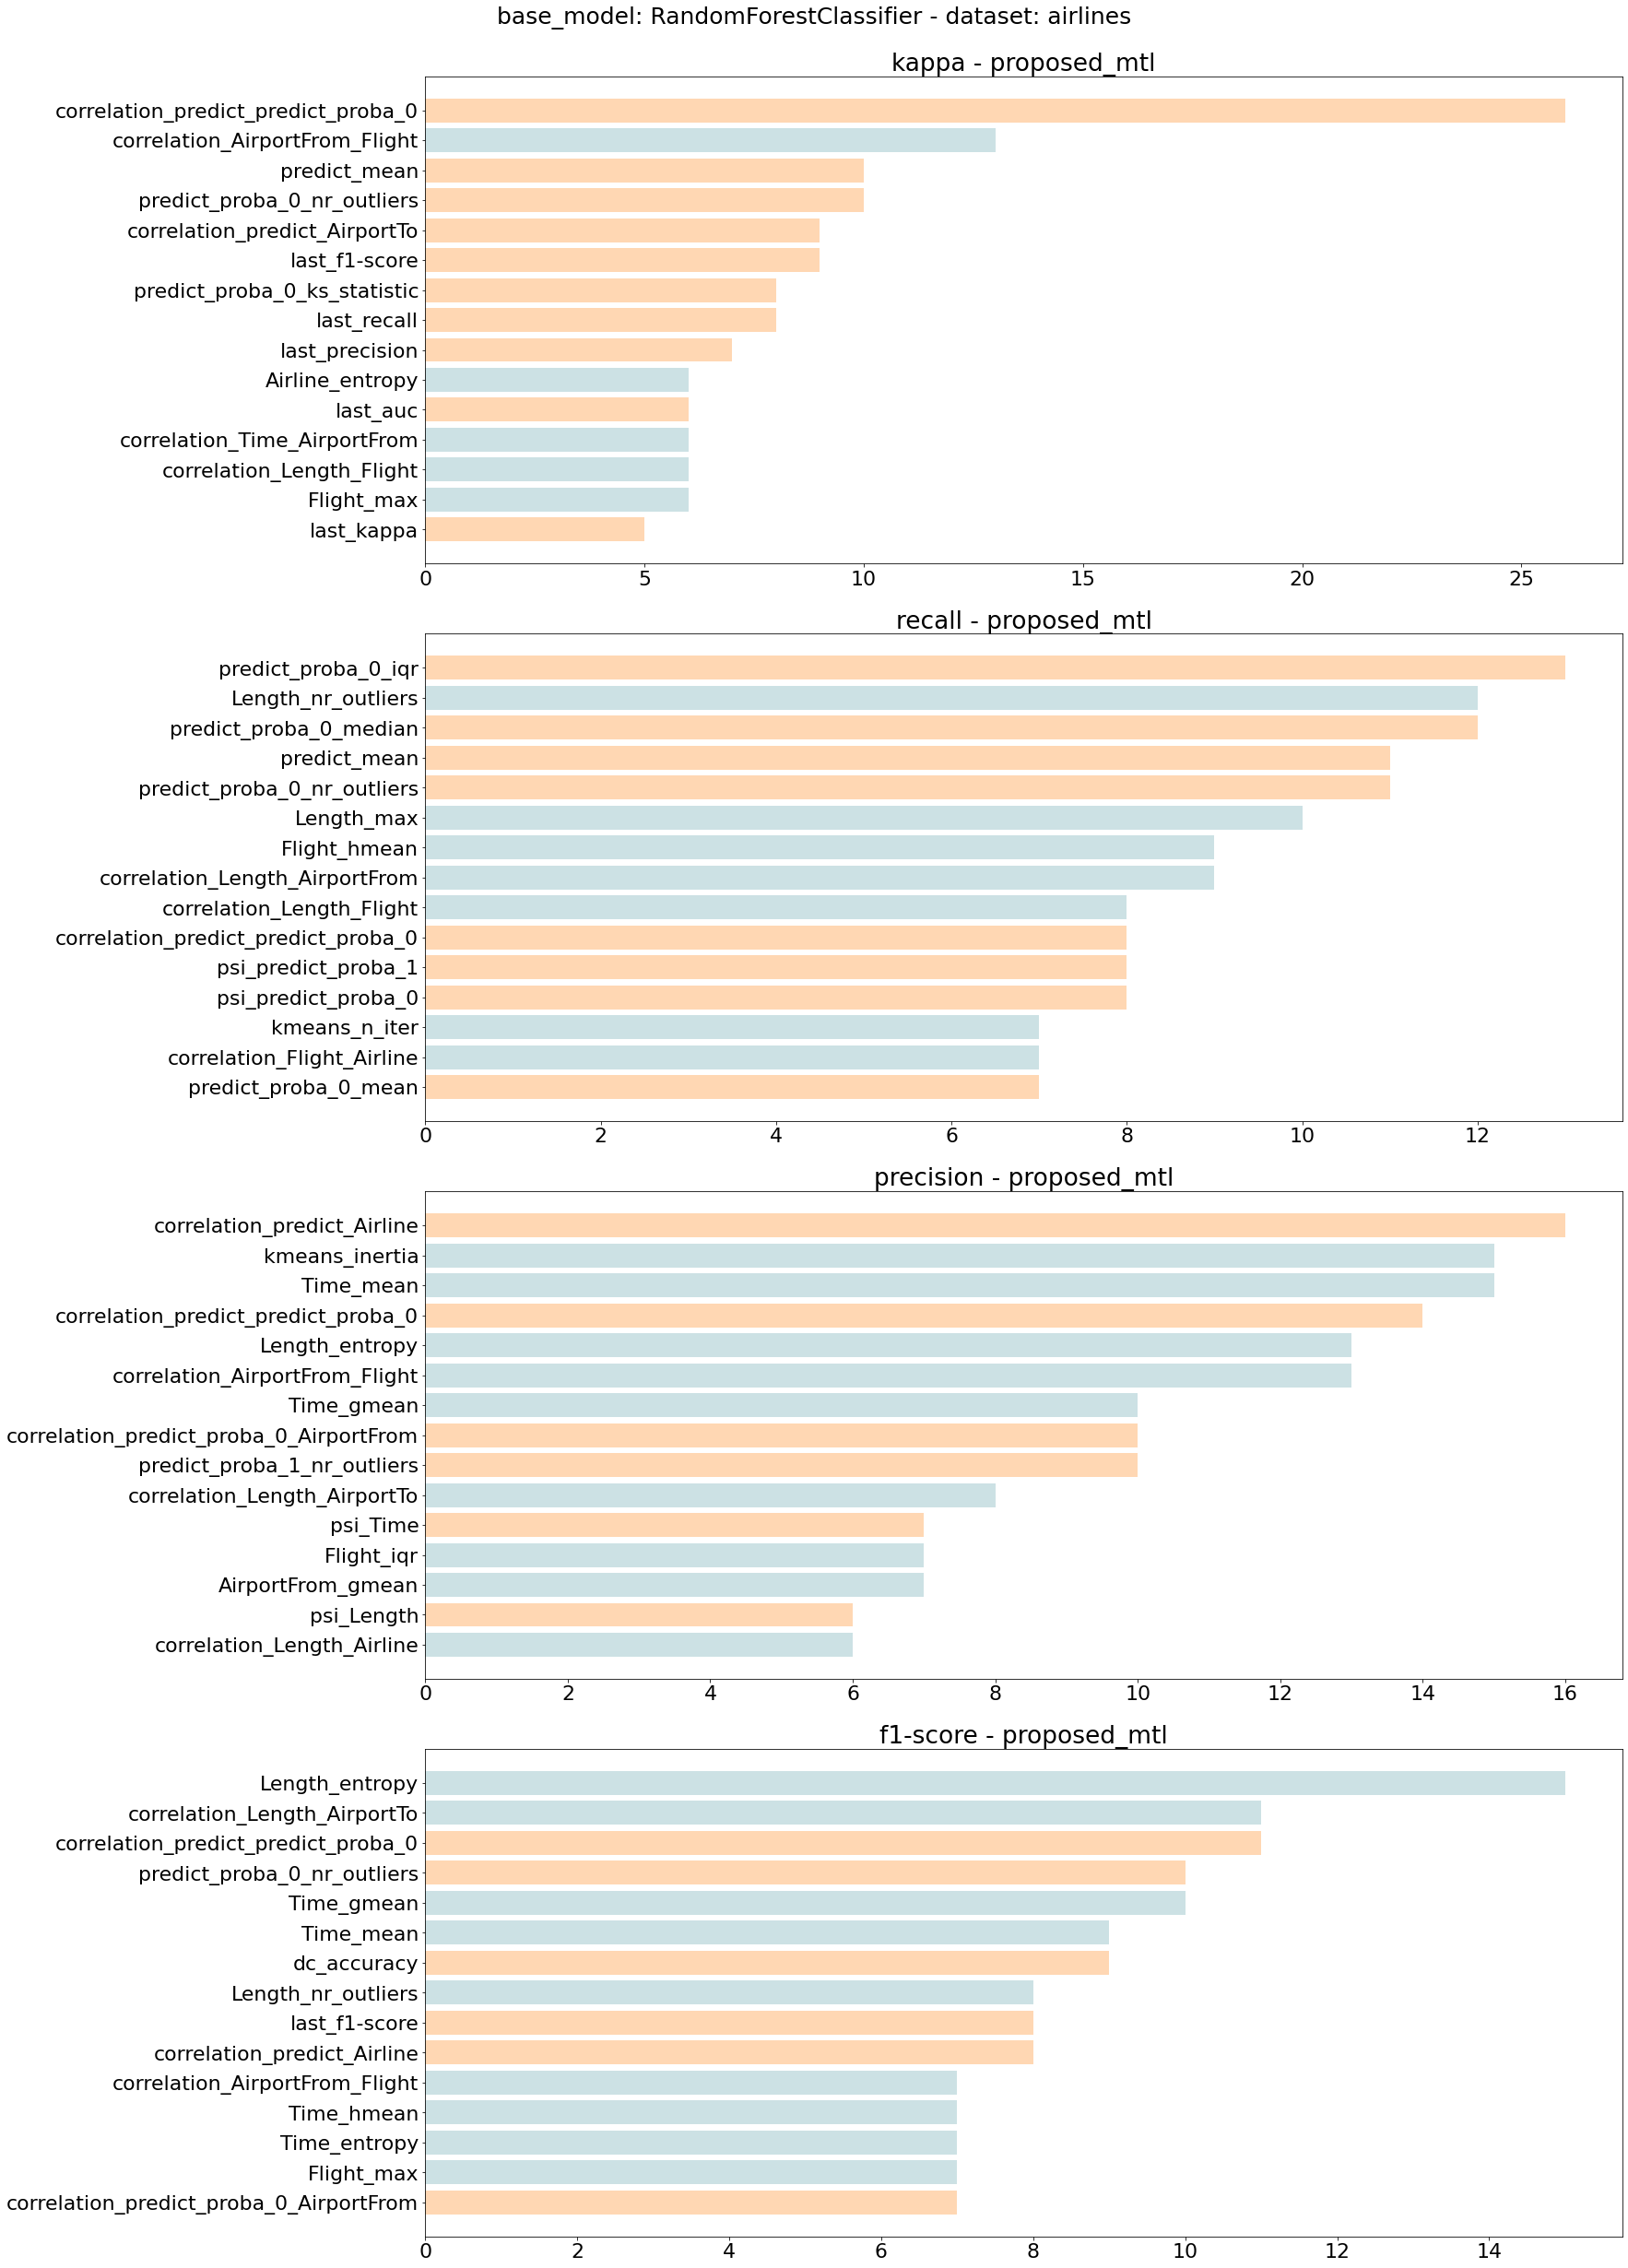

In [8]:
run(base_model="RandomForestClassifier", dataset="airlines", feature_fraction=FINAL_FEATURE_FRACTION["airlines"])

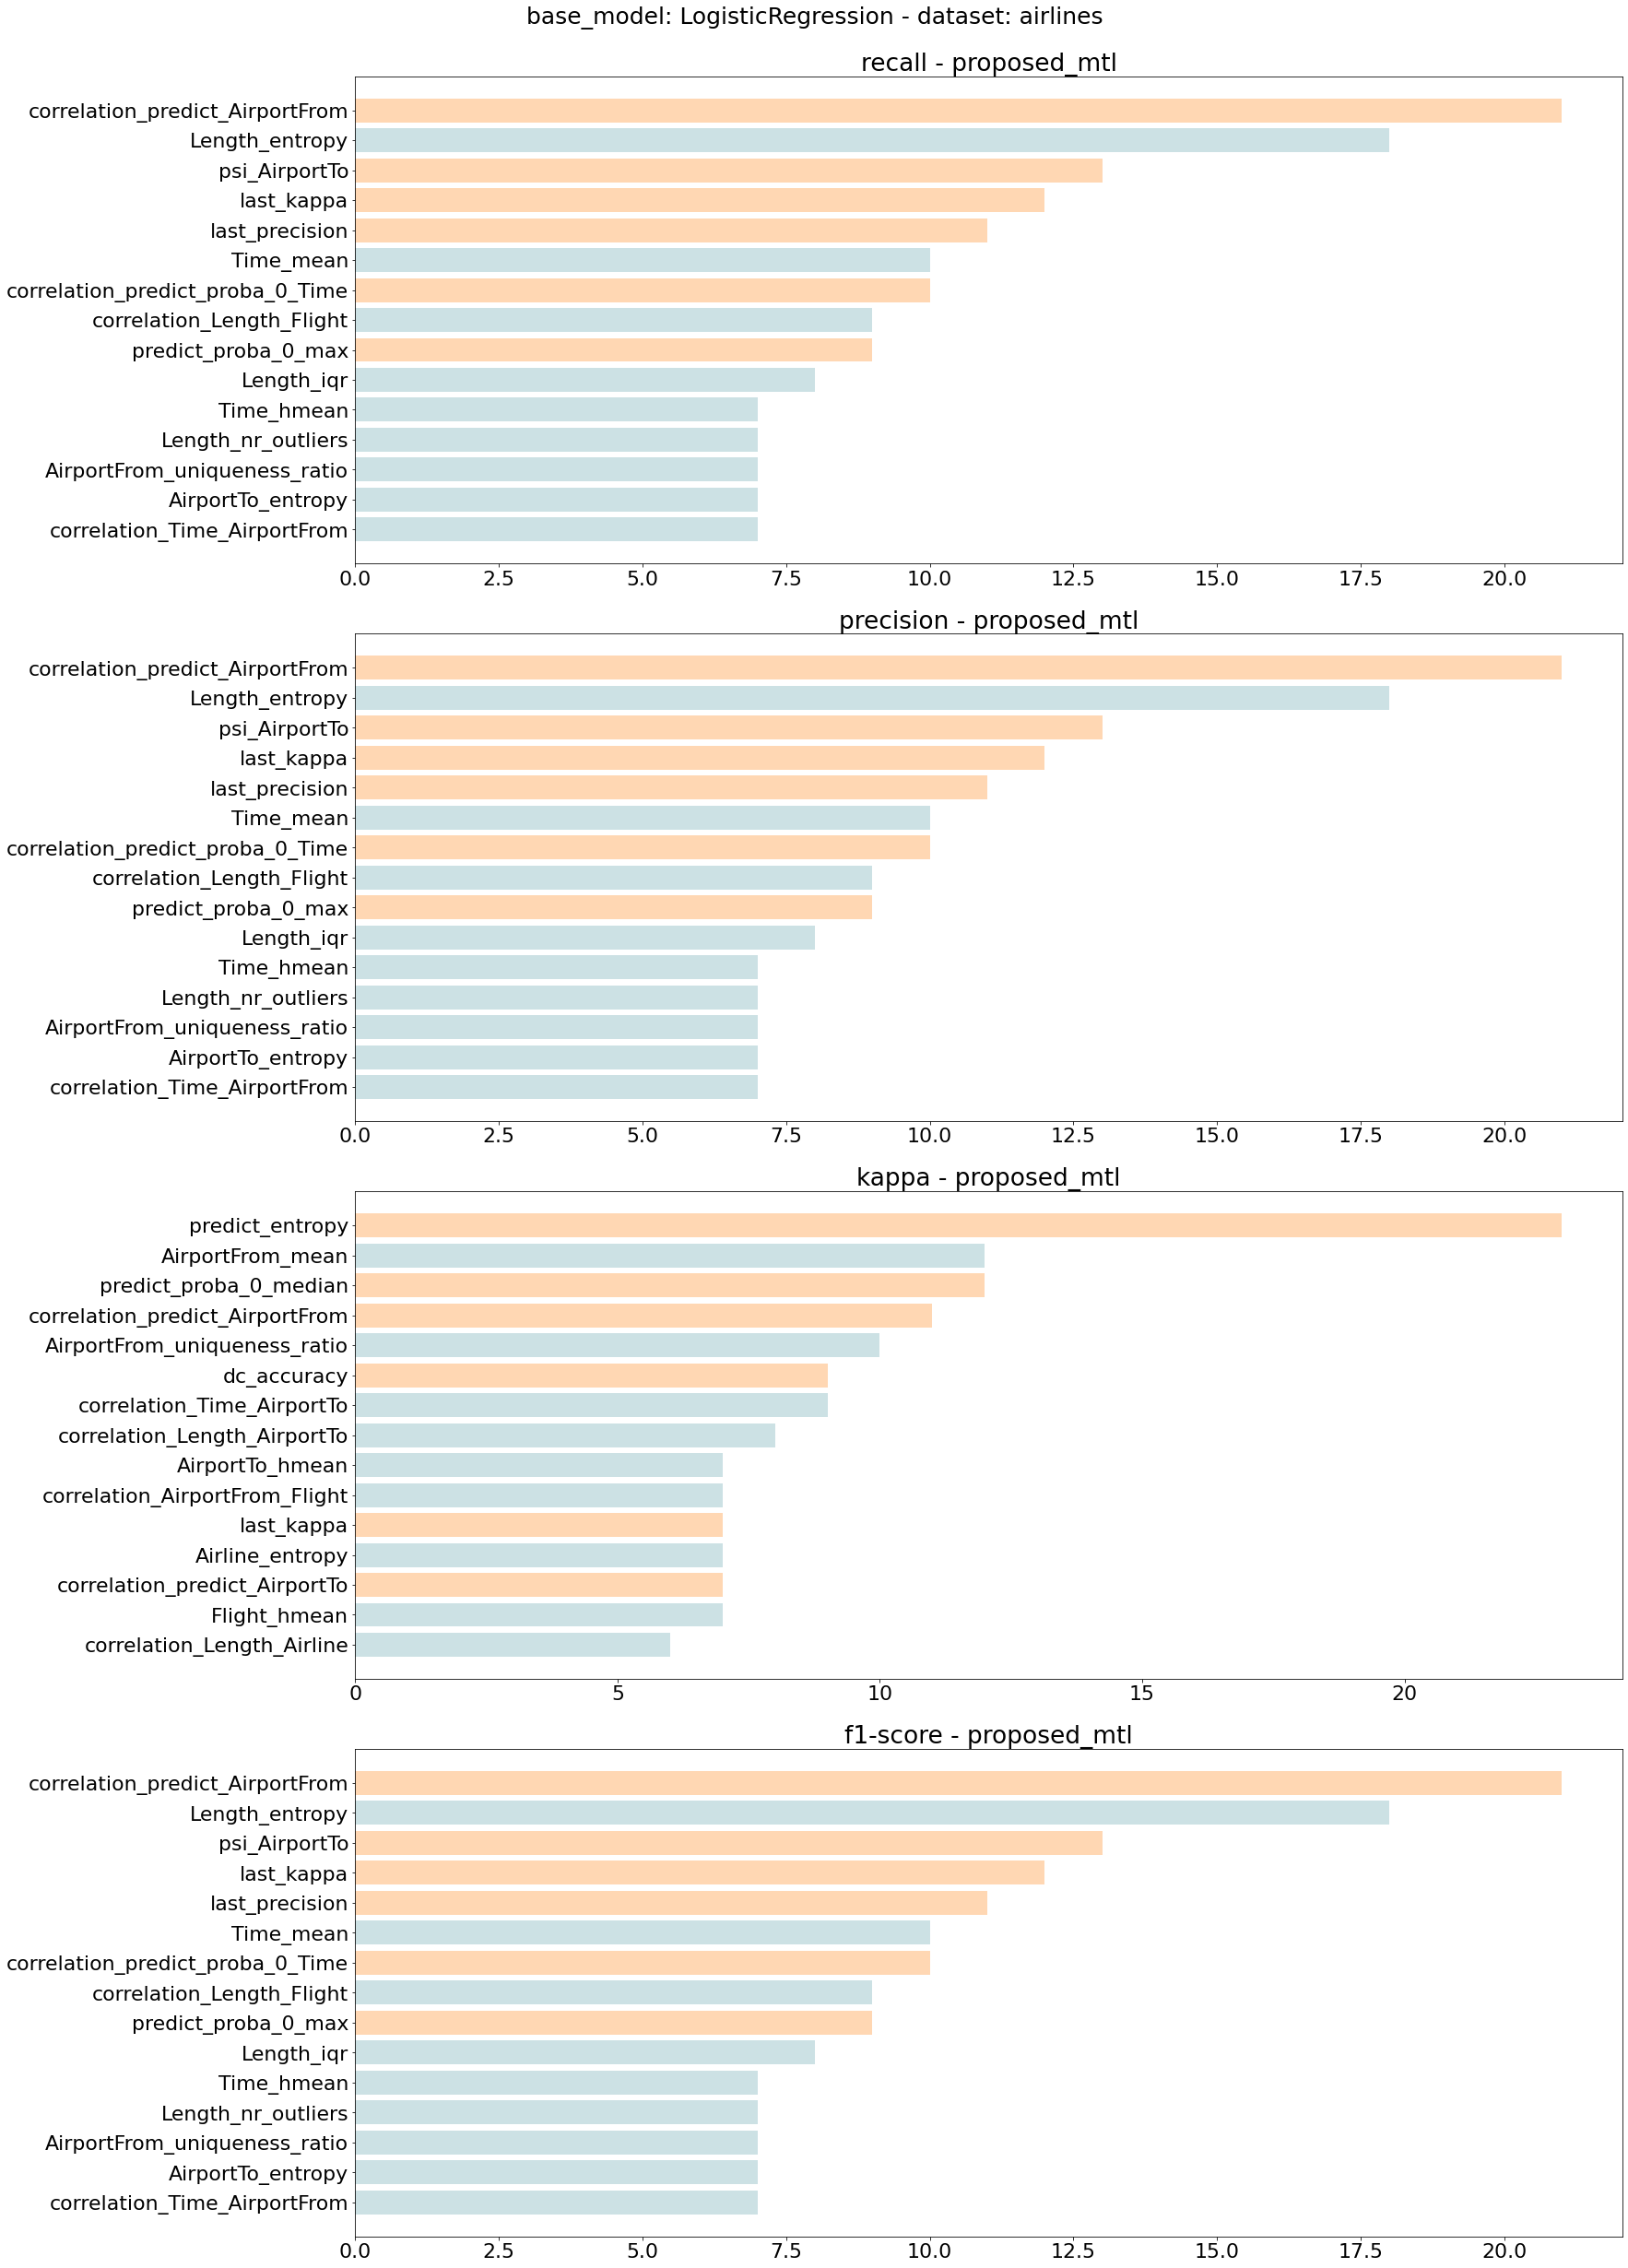

In [9]:
run(base_model="LogisticRegression", dataset="airlines", feature_fraction=FINAL_FEATURE_FRACTION["airlines"])

# powersupply

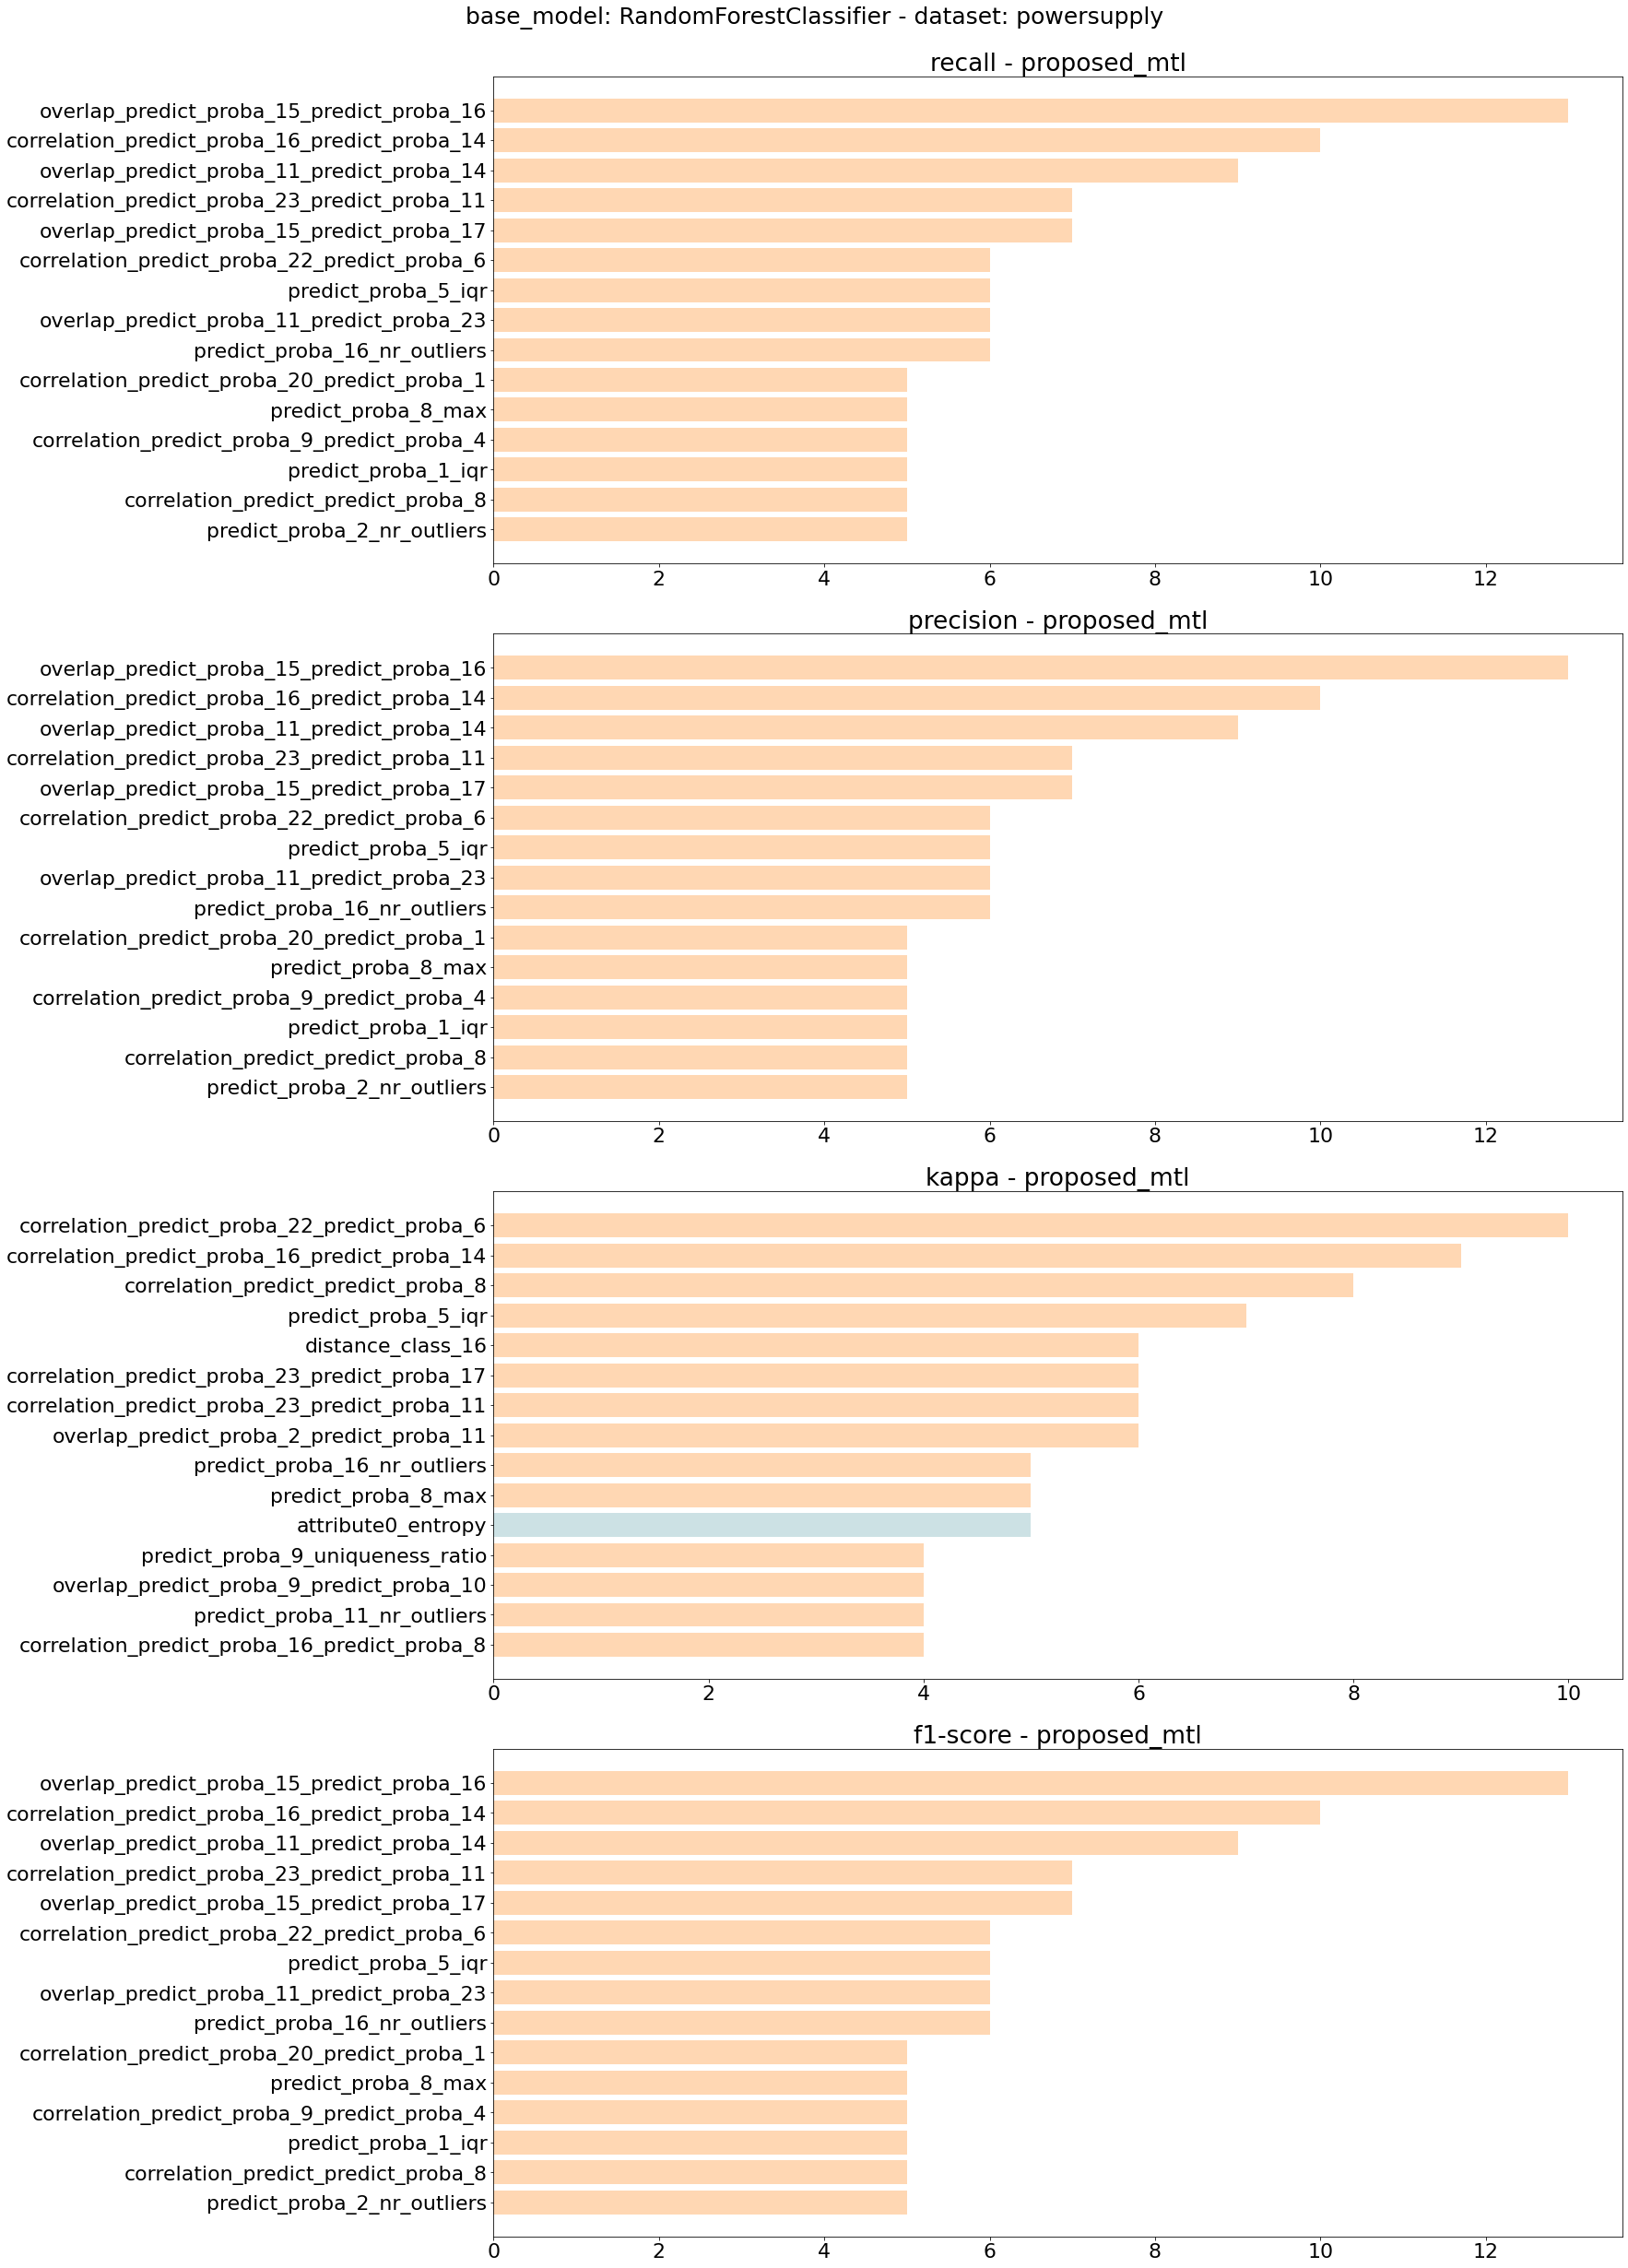

In [10]:
run(base_model="RandomForestClassifier", dataset="powersupply", feature_fraction=FINAL_FEATURE_FRACTION["powersupply"])

# rialto

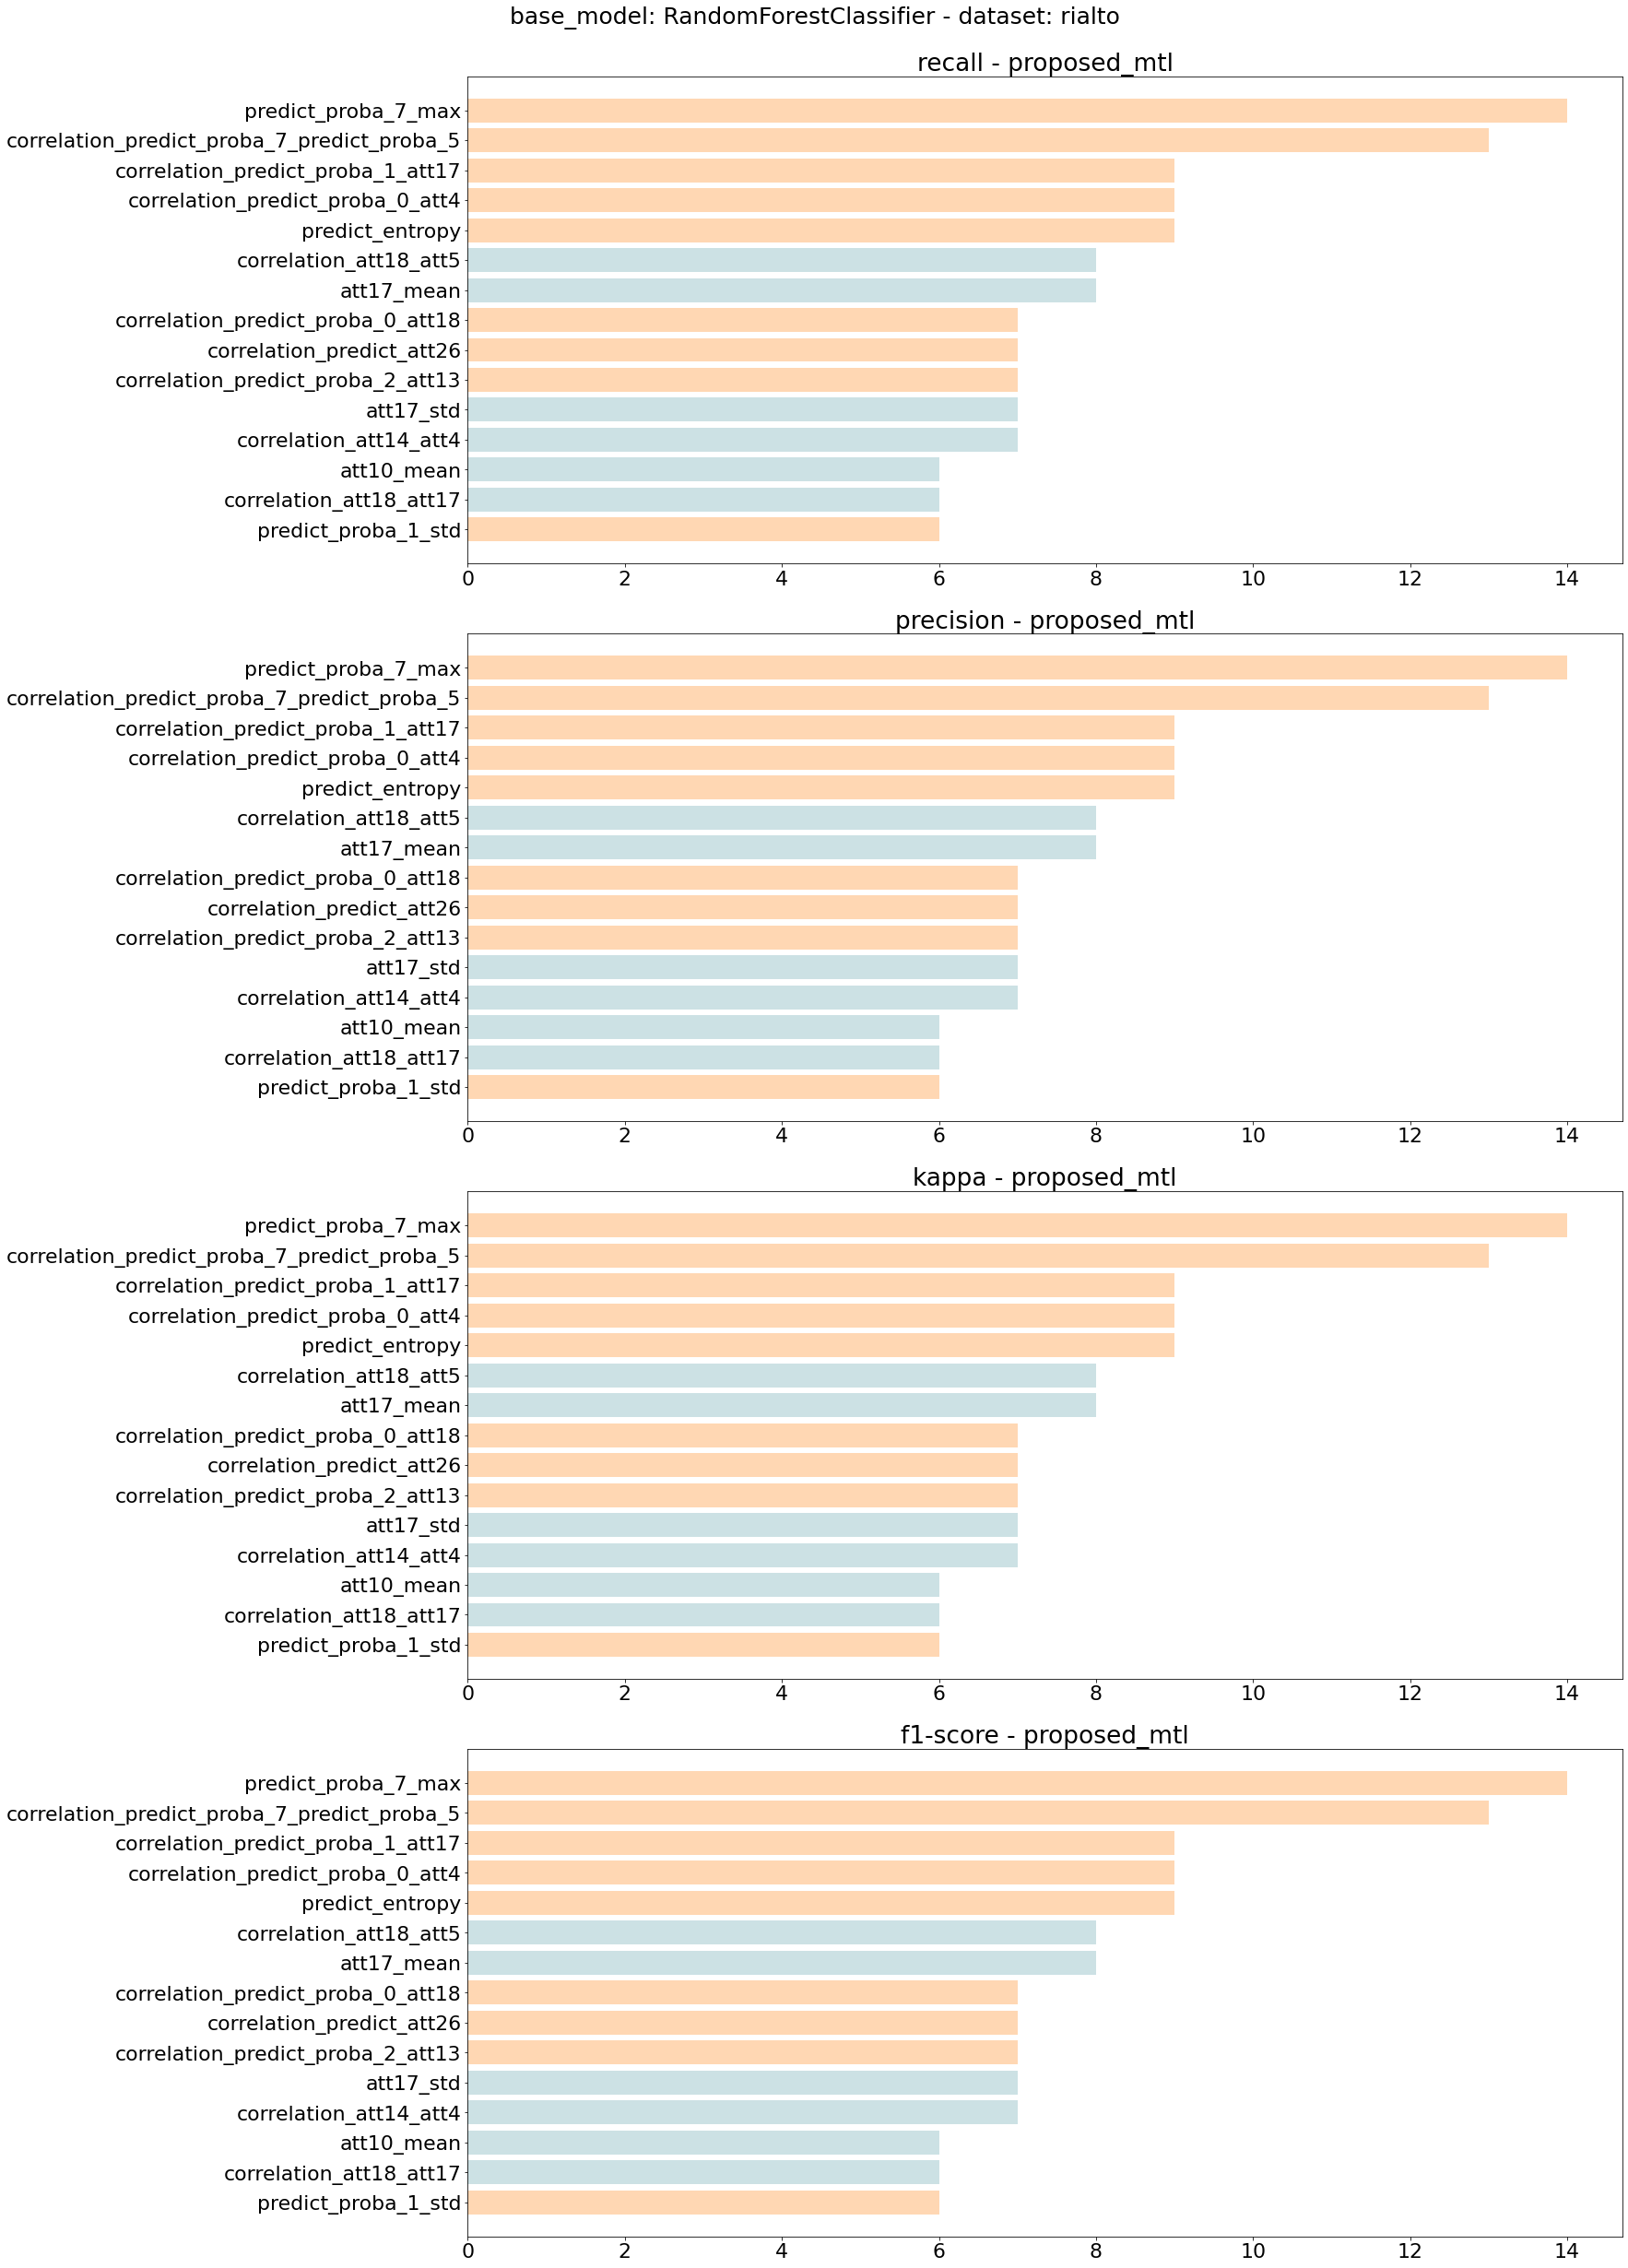

In [11]:
run(base_model="RandomForestClassifier", dataset="rialto", feature_fraction=FINAL_FEATURE_FRACTION["rialto"])

# Find most important features on average

In [12]:
DRIFT_METRICS_DICT = {
    "psi_": "PsiCalculator",
    "overlap_": "OmvPht",
    "omv_pth": "OmvPht",
    "dc_accuracy": "DomainClassifier",
    "dc_drift_flag": "DomainClassifier",
    "_ks_statistic": "SqsiCalculator",
    "_ks_pvalue": "SqsiCalculator",
    "sqsi_drift_flag": "SqsiCalculator",
    "distance_class_": "Udetector",
    "u_detect_drift_flag": "Udetector",
    "compacness": "ClusteringMetrics",
    "kmeans_n_iter": "ClusteringMetrics",
    "kmeans_n_clusters": "ClusteringMetrics",
    "kmeans_inertia": "ClusteringMetrics",
    "_uniqueness_ratio": "MiscellaneousMetrics",
    "prop_pca": "MiscellaneousMetrics",
    "_sparsity": "MiscellaneousMetrics",
    "predict": "ScoringMetrics",
    "last": "ScoringMetrics",
}

BASE_MODELS = [
    "RandomForestClassifier",
    "SVC",
    "LogisticRegression",
    "DecisionTreeClassifier"
]

COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#6aa4c8ff", # blue
    "#d9d9d9", # grey
    "#E08637", # dark orange
    "#6aa4c8ff", # blue
    "#F5E3AD", # yellow
    "#A2D4B0", # greenn diff
    "#5B919A", # dark green
    ]

DATASETS = list(FINAL_FEATURE_FRACTION.keys())

def get_mfe_type(row):
    for key, value in DRIFT_METRICS_DICT.items():
        if key in row["feature"]:
            return value
    return "StatsMetrics"

def get_imps(base_model: str="RandomForestClassifier", dataset: str="electricity", feature_fraction: int=100, normalize: bool=True, top_perc_feat: int=None):
    data = _load_data(base_model, dataset, feature_fraction)
    data.pop("auc", None)
    imp_df = _get_mean_importances(data)
    imp_df = imp_df[imp_df["type"] == "proposed_mtl"]
    imp_df["base_model"] = base_model
    imp_df["dataset"] = dataset
    imp_df["mfe_type"] = imp_df.apply(get_mfe_type, axis=1)
    if normalize:
        imp_df["importance"] = (imp_df["importance"]-imp_df["importance"].min())/(imp_df["importance"].max()-imp_df["importance"].min())
    if top_perc_feat:
        if top_perc_feat < 1:
            top_perc_feat = int(top_perc_feat*imp_df.shape[0])
        imp_df = imp_df.sort_values(by=["importance"]).tail(top_perc_feat)
    return imp_df

def plot_bars(importances,  col_name="importance", color="#cce1e4", normalize=True):
    grouped_imps = importances[["mfe_type", col_name]].groupby("mfe_type").sum()
    if normalize:
        total = grouped_imps.sum()
        grouped_imps = grouped_imps/total
    df_plot = grouped_imps[col_name].sort_index()
    df_plot.plot.barh(figsize=(10,6), fontsize=16, color=color)

# TO GET LEGEND
# def plot_bars(importances,  col_name="importance", color="#cce1e4"):
#     grouped_imps = importances[["mfe_type", col_name]].groupby("mfe_type").sum()
#     df_plot = grouped_imps[[col_name]].sort_index()
#     porcent = 100.*df_plot[col_name]/df_plot[col_name].sum()
#     labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(df_plot.index, porcent)]
#     df_plot.T.plot.barh(figsize=(10,6), fontsize=16, color=color).legend(labels, loc='upper right', prop={'size': 16}, bbox_to_anchor=(1.7, 0.5))

## Considering all cases

In [13]:
all_imps = pd.DataFrame()
for base_model in BASE_MODELS:
    for dataset in DATASETS:
        this_df = get_imps(base_model=base_model, dataset=dataset, feature_fraction=FINAL_FEATURE_FRACTION[dataset])
        all_imps = pd.concat([all_imps, this_df], ignore_index=True)
all_imps[["mfe_type", "importance"]].groupby("mfe_type").mean()

,importance
mfe_type,
ClusteringMetrics,0.094328
DomainClassifier,0.043332
MiscellaneousMetrics,0.022657
OmvPht,0.090485
PsiCalculator,0.136666
ScoringMetrics,0.071091
SqsiCalculator,0.104905
StatsMetrics,0.145175
Udetector,0.086602


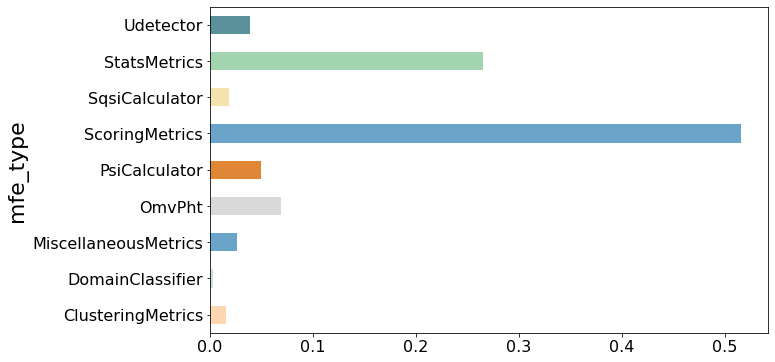

In [14]:
plot_bars(all_imps, color=COLORS)

In [15]:
# grouped_df = all_imps[["mfe_type", "importance"]].groupby("mfe_type").sum()

# x = grouped_df.index
# y = grouped_df["importance"].sort_index()
# porcent = 100.*y/y.sum()
# labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(x, porcent)]

# y.plot.pie(
#     figsize=(20,7),
#     fontsize=16,
#     colors=COLORS,
# ).legend(labels, loc='upper right', prop={'size': 16}, bbox_to_anchor=(1.9, 0.5))

# Count

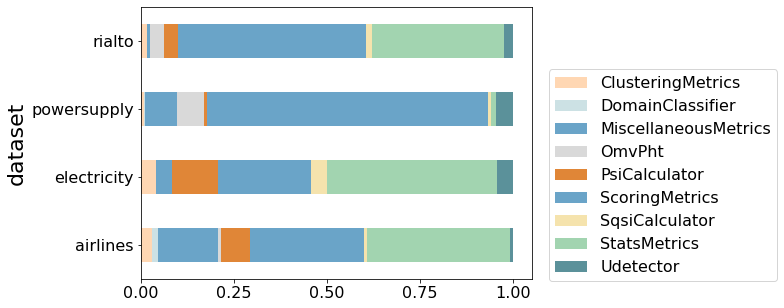

In [16]:
specific_df = all_imps[(all_imps["base_model"] == "RandomForestClassifier") & (all_imps["meta_label"] == "recall")]
feat_count = specific_df.groupby(["dataset", "mfe_type"]).count()[["importance"]].reset_index()
feat_count = feat_count.pivot(index="dataset", columns="mfe_type")
feat_count.columns = feat_count.columns.droplevel()
feat_count = feat_count.div(feat_count.sum(axis=1), axis=0)

feat_count.plot.barh(figsize=(7,5), fontsize=16, color=COLORS, stacked=True).legend(loc='best', prop={'size': 16}, bbox_to_anchor=(1.65, 0.8))

In [17]:
feat_count

mfe_type,ClusteringMetrics,DomainClassifier,MiscellaneousMetrics,OmvPht,PsiCalculator,ScoringMetrics,SqsiCalculator,StatsMetrics,Udetector
dataset,,,,,,,,,
airlines,0.030769,0.015385,0.161538,0.007692,0.076923,0.307692,0.007692,0.384615,0.007692
electricity,0.041667,NaN,0.041667,NaN,0.125000,0.250000,0.041667,0.458333,0.041667
powersupply,0.007505,0.003752,0.086304,0.071295,0.009381,0.754221,0.007505,0.013133,0.046904
rialto,0.015504,NaN,0.007752,0.038760,0.038760,0.503876,0.015504,0.356589,0.023256


## Importance per dataset

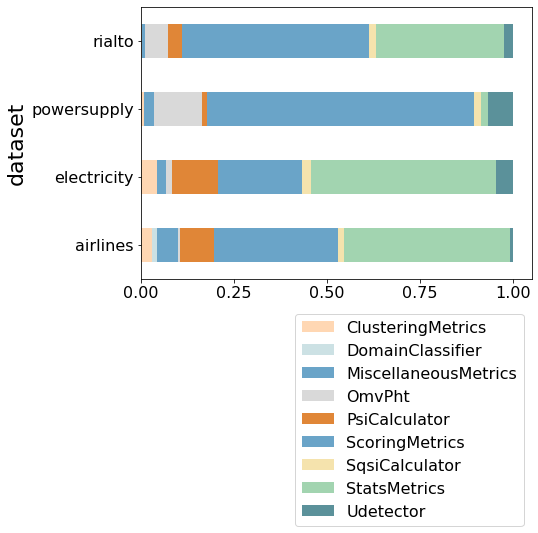

In [18]:
total_imp_dict = all_imps[["dataset", "importance"]].groupby(["dataset"]).sum().to_dict()["importance"]
dataset_df = all_imps[["dataset", "mfe_type", "importance"]].groupby(["dataset", "mfe_type"]).sum().reset_index()
dataset_df["importance"] = dataset_df.apply(lambda  x: x["importance"]/total_imp_dict[x["dataset"]], axis=1)
dataset_df = dataset_df.pivot(index="dataset", columns="mfe_type")
dataset_df.columns = dataset_df.columns.droplevel()
dataset_df.plot.barh(figsize=(7, 5), fontsize=16, color=COLORS, stacked=True).legend(loc='best', prop={'size': 16}, bbox_to_anchor=(1, -0.1))